In [1]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision
import  matplotlib.pyplot as plt

In [13]:
from datetime import datetime

print(datetime.now().strftime("%d-%m-%Y"))

22-02-2024


## Data

In [2]:
DATA_ROOT = "../data/raw"
test_root = os.path.join(DATA_ROOT, "Test")
train_root = os.path.join(DATA_ROOT, "Train")

In [3]:
class ImageClassificationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform # TODO 
        self.image_paths = os.listdir(root)
        self.classes = [p.split("_")[1].split(".")[0] for p in self.image_paths]
        self.classes_unique = set(self.classes)
        self.ind_to_class = {ind:cl for ind,cl in enumerate(self.classes_unique)}
        self.class_to_ind = {value:key for key, value in self.ind_to_class.items()}
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        full_image_path = os.path.join(self.root, image_path)
        label_name = image_path.split("_")[1].split(".")[0] # OR: label = self.classes[index]
        label = self.class_to_ind[label_name]
        img = Image.open(full_image_path).convert(mode = "RGB") #OR: .convert(mode = "L") because greyscale (but then transform need to match)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
# transform = None

In [5]:
full_train_dataset = ImageClassificationDataset(train_root, transform=transform)
test_dataset = ImageClassificationDataset(test_root, transform=transform)

In [6]:
# Dataloaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## Model

In [7]:
import torch.nn as nn 
import torch.nn.functional as F

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # print(f'input X {x.size()}')
        x = self.pool(F.relu(self.conv1(x)))
        # print(f'X1 {x.size()}')
        x = self.pool(F.relu(self.conv2(x)))
        # print(f'X2 {x.size()}')
        x = torch.flatten(x, start_dim=1) #all except batch dimension
        # print(f'X3 {x.size()}')
        x = F.relu(self.fc1(x))
        # print(f'X4 {x.size()}')
        x = F.relu(self.fc2(x))
        # print(f'X5 {x.size()}')
        x = self.fc3(x)
        # print(f'X6 {x.size()}')
        return x
    
cnn = SimpleCNN()

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum=0.9)

In [10]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        images, labels = data

        # let's zero the gradient
        optimizer.zero_grad()

        # forward and backward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4: 
            print(f'[{epoch}, {i:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0

print("Training finished!")

Epoch 0
[0,     4] loss: 0.692
Epoch 1
[1,     4] loss: 0.687
Epoch 2
[2,     4] loss: 0.680
Epoch 3
[3,     4] loss: 0.673
Epoch 4
[4,     4] loss: 0.664
Epoch 5
[5,     4] loss: 0.653
Epoch 6
[6,     4] loss: 0.640
Epoch 7
[7,     4] loss: 0.617
Epoch 8
[8,     4] loss: 0.588
Epoch 9
[9,     4] loss: 0.555
Epoch 10
[10,     4] loss: 0.526
Epoch 11
[11,     4] loss: 0.471
Epoch 12
[12,     4] loss: 0.424
Epoch 13
[13,     4] loss: 0.386
Epoch 14
[14,     4] loss: 0.332
Epoch 15
[15,     4] loss: 0.287
Epoch 16
[16,     4] loss: 0.246
Epoch 17
[17,     4] loss: 0.234
Epoch 18
[18,     4] loss: 0.222
Epoch 19
[19,     4] loss: 0.193
Training finished!


In [15]:
# Save the model
model_path = f"../models/model1_simple_cnn_v1_bs{BATCH_SIZE}_e{EPOCHS}_23Feb.pth"
torch.save(cnn.state_dict(), model_path)

## TEST

In [11]:
def imshow(img):
    print(type(img))
    img = img / 2 + 0.5 #if denormalization is needed
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [12]:
ind_to_class = full_train_dataset.ind_to_class
ind_to_class

{0: 'Lateral', 1: 'AP'}

8
<class 'torch.Tensor'>


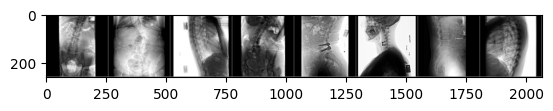

Ground Truth:  AP AP Lateral Lateral Lateral Lateral Lateral Lateral


In [13]:
TEST_BATCH_SIZE = 8
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = TEST_BATCH_SIZE, shuffle = True)
dataiter = iter(test_loader)
images, labels = next(dataiter)
labels = labels.tolist()
print(len(labels))

imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join(f'{ind_to_class[labels[j]]}' for j in range(TEST_BATCH_SIZE)))

In [16]:
cnn = SimpleCNN()
cnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
outputs = cnn(images)

In [18]:
_, predicted = torch.max(outputs, 1)
predicted = predicted.tolist()

In [19]:
print("Predictions: ", " ".join(f'{ind_to_class[predicted[j]]}' for j in range(TEST_BATCH_SIZE)))

Predictions:  AP AP AP AP AP AP AP AP


## Pipeline

In [20]:
# for logging
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexaatm. Use `wandb login --relogin` to force relogin


True

In [21]:
# for configs
import yaml

CONFIG_PATH = "../configs/model1.yaml"
with open(CONFIG_PATH, 'r') as file:
    hyperparam = yaml.safe_load(file)

print(hyperparam)

{'lr': 0.001, 'epochs': 10, 'batch_size': 8, 'data_root': 'data/raw', 'name': 'model1', 'data_augm': False}


In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.optim as optim
import torchvision.transforms as transforms

def make(cfg):
    # 1 - prepare data
    test_root = os.path.join("..",cfg.data_root, "Test")
    train_root = os.path.join("..", cfg.data_root, "Train")

    transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    )

    full_train_dataset = ImageClassificationDataset(train_root, transform=transform)
    test_dataset = ImageClassificationDataset(test_root, transform=transform)

    # split train into train and val
    train_ind, val_ind = train_test_split(
        range(len(full_train_dataset)), 
        stratify=full_train_dataset.classes,
        test_size=0.2,
        random_state=1)

    train_dataset = Subset(full_train_dataset, train_ind)
    val_dataset = Subset(full_train_dataset, val_ind)

    # loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = cfg.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = cfg.batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = cfg.batch_size, shuffle = True)

    # 2 - prepare model
    model = SimpleCNN()


    # 3 - prepare loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = cfg.lr, momentum=0.9)

    return model, train_loader, val_loader, test_loader, criterion, optimizer

In [28]:
from tqdm import tqdm

def validate(model, val_loader, criterion):
    # print("Starting validation...")
    with torch.no_grad():
        # for data in tqdm(val_loader):
        for data in val_loader:
            images, labels = data

            # only forward step
            outputs = model(images)
            loss = criterion(outputs, labels)

    return loss

def train(model, train_loader, val_loader, criterion, optimizer, cfg):
    print("Starting training...")
    print("cfg=", cfg, "type=", type(cfg))
    wandb.watch(model, criterion, log="all", log_freq=10)

    print("cfg.epochs=", cfg.epochs)

    for epoch in tqdm(range(cfg.epochs)):
        # print(f"Epoch {epoch} / {cfg.epochs}")
        model.train()
        for i, data in enumerate(train_loader):
            images, labels = data

            # zero the gradient
            optimizer.zero_grad()

            # forward and backward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # log
            wandb.log({"epoch": epoch, "train_loss": loss.item()}) #, "train_step": i

        
        # validate
        model.eval()
        val_loss = validate(model, val_loader, criterion)
        
        # log
        wandb.log({"epoch": epoch, "val_loss": val_loss.item()})

    print("Training finished!")

    # Save the model
    print("Saving a model!")
    model_path = f"../models/model1_simple_cnn_v1_bs{cfg.batch_size}_e{cfg.epochs}.pth"
    torch.save(cnn.state_dict(), model_path)

In [24]:
from torchmetrics.classification import BinaryAccuracy, Accuracy, BinaryF1Score, F1Score, BinaryAUROC, BinaryConfusionMatrix, MulticlassConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
import io

# ref: https://lightning.ai/docs/torchmetrics/stable/classification/f1_score.html
# accuracy = Accuracy(task="multiclass", num_classes=2)
# to plot values: fig_, ax_ = metric.plot()

def test(model, test_loader):
    print("Starting testing ...")
    model.eval()

    acc = BinaryAccuracy()
    f1score = BinaryF1Score()
    auroc = BinaryAUROC()
    conf_matrix = BinaryConfusionMatrix()

    with torch.no_grad():

        for data in tqdm(test_loader):
            images, labels = data

            # only forward step
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # calculate metrics
            acc.update(preds, labels)
            f1score.update(preds, labels)
            auroc.update(preds, labels)
            conf_matrix.update(preds, labels)

    total_acc = acc.compute().item()
    total_f1score = f1score.compute().item()
    total_auroc = auroc.compute().item()
    total_conf_matrix = conf_matrix.compute()

    stats = {
        "Accuracy": total_acc, 
        "F1Score": total_f1score, 
        "AUROC":total_auroc, 
        "Confusion_Matrix_array": np.array(total_conf_matrix)
    }

    wandb.log(stats)

    # fig_, ax_ = conf_matrix.plot()


    # Plot confusion matrix
    # plt.ioff()
    # disp = ConfusionMatrixDisplay(confusion_matrix=np.array(total_conf_matrix))
    # buf = io.BytesIO()
    # plt.savefig(buf, format='png')
    # buf.seek(0)

    # wandb.log({"Confusion_Matrix": wandb.Image(buf)})

    return stats


In [25]:
def model_pipeline(hyperparameters):

    with wandb.init(project="xray-classifier", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, val_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, val_loader, criterion, optimizer, config)

      # and test its final performance
      stats = test(model, test_loader)

    wandb.finish()

    return model, stats

In [29]:
model, stats = model_pipeline(hyperparam)

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
Starting training...
cfg= {'lr': 0.001, 'epochs': 10, 'batch_size': 8, 'data_root': 'data/raw', 'name': 'model1', 'data_augm': False} type= <class 'wandb.sdk.wandb_config.Config'>
cfg.epochs= 10


100%|██████████| 10/10 [01:39<00:00,  9.98s/it]


Training finished!
Saving a model!
Starting testing ...


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


AUROC,▁
Accuracy,▁
F1Score,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,▇▇▇▇▇▇▇▇▇▆▆▆▅▆▅█▆▆▅▇▆▅▅▅▅▃▆▆▃▃▂▇▂▃▄▁▅▁▃▂
val_loss,▄▄▃▃▅▄▇▂▁█
AUROC,0.52747
Accuracy,0.51852
F1Score,0.38095
epoch,9
train_loss,0.25472
